Data-Size vs Accuracy Experiment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


In [3]:
# Load flux sequences
flux_sequences = np.load("flux_sequences.npy")
flux_kepler_ids = np.load("flux_kepler_ids.npy")

# Load multimodal dataset
merged_df = pd.read_csv("final_multimodal_dataset.csv")

# Match sequences to multimodal data
id_to_seq = {k: seq for k, seq in zip(flux_kepler_ids, flux_sequences)}

matched_seqs, matched_tabular, matched_labels = [], [], []
tabular_features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_prad', 'koi_score', 'koi_period']

for _, row in merged_df.iterrows():
    kepler_id = row['Kepler_ID']
    if kepler_id in id_to_seq:
        matched_seqs.append(id_to_seq[kepler_id])
        matched_tabular.append(row[tabular_features].values)
        matched_labels.append(row['label'])

X_seq = np.array(matched_seqs)
X_tab = np.array(matched_tabular)
y = np.array(matched_labels)

# Scale tabular data
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab)

print(f"✅ Loaded and matched {len(X_seq)} samples.")


✅ Loaded and matched 1411 samples.


In [4]:
def build_transformer_tabular_model(seq_shape, tab_shape):
    seq_input = tf.keras.Input(shape=(seq_shape, 1))
    x_seq = tf.keras.layers.LayerNormalization()(seq_input)
    x_seq = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=64)(x_seq, x_seq)
    x_seq = tf.keras.layers.GlobalAveragePooling1D()(x_seq)

    tab_input = tf.keras.Input(shape=(tab_shape,))
    x_tab = tf.keras.layers.Dense(64, activation='relu')(tab_input)
    x_tab = tf.keras.layers.Dropout(0.3)(x_tab)
    x_tab = tf.keras.layers.Dense(32, activation='relu')(x_tab)

    combined = tf.keras.layers.Concatenate()([x_seq, x_tab])
    x = tf.keras.layers.Dense(64, activation='relu')(combined)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, tab_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [7]:
data_sizes = [0.25, 0.75, 1.0]
accuracies = []

for size in data_sizes:
    print(f"\n🚀 Training with {int(size*100)}% of data")

    if size < 1.0:
        # Subsample data
        X_seq_sub, _, X_tab_sub, _, y_sub, _ = train_test_split(
            X_seq, X_tab_scaled, y, train_size=size, random_state=42, stratify=y
        )
    else:
        # Use entire dataset if size is 1.0
        X_seq_sub, X_tab_sub, y_sub = X_seq, X_tab_scaled, y

    # Split into train-test (80-20)
    X_seq_train, X_seq_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
        X_seq_sub, X_tab_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
    )

    # Build and train model
    model = build_transformer_tabular_model(X_seq_train.shape[1], X_tab_train.shape[1])

    history = model.fit(
        [X_seq_train[..., np.newaxis], X_tab_train], y_train,
        validation_split=0.2,
        epochs=15,  # adjust if needed
        batch_size=32,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
        verbose=1
    )

    # Evaluate accuracy
    loss, accuracy = model.evaluate([X_seq_test[..., np.newaxis], X_tab_test], y_test, verbose=0)
    accuracies.append(accuracy)
    print(f"✅ Accuracy ({int(size*100)}% data): {accuracy:.4f}")



🚀 Training with 25% of data
Epoch 1/15
7/7 [==============================] - 3s 202ms/step - loss: 0.6537 - accuracy: 0.6473 - val_loss: 0.5892 - val_accuracy: 0.9123
Epoch 2/15
7/7 [==============================] - 1s 165ms/step - loss: 0.6017 - accuracy: 0.8527 - val_loss: 0.5265 - val_accuracy: 1.0000
Epoch 3/15
7/7 [==============================] - 1s 167ms/step - loss: 0.5478 - accuracy: 0.9286 - val_loss: 0.4508 - val_accuracy: 1.0000
Epoch 4/15
7/7 [==============================] - 1s 185ms/step - loss: 0.4579 - accuracy: 0.9509 - val_loss: 0.3638 - val_accuracy: 1.0000
Epoch 5/15
7/7 [==============================] - 1s 179ms/step - loss: 0.3896 - accuracy: 0.9688 - val_loss: 0.2697 - val_accuracy: 1.0000
Epoch 6/15
7/7 [==============================] - 1s 180ms/step - loss: 0.2948 - accuracy: 0.9688 - val_loss: 0.1907 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 1s 173ms/step - loss: 0.2134 - accuracy: 0.9821 - val_loss: 0.1275 - val_accuracy

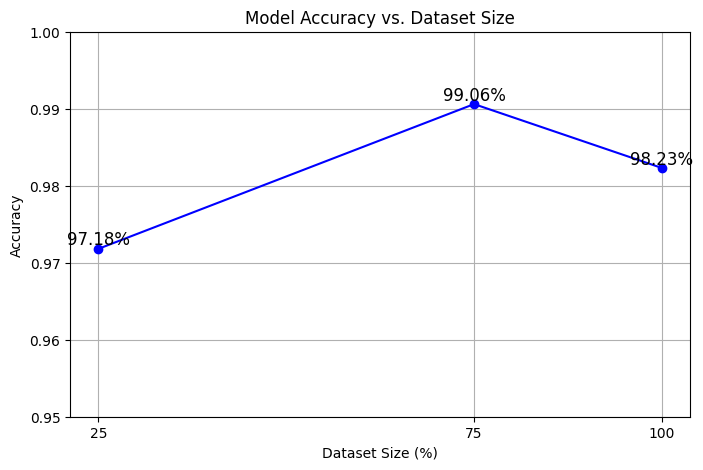

In [8]:
sizes = [25, 75, 100]
accuracies = [0.9718, 0.9906, 0.9823]

plt.figure(figsize=(8, 5))
plt.plot(sizes, accuracies, marker='o', linestyle='-', color='blue')

for size, acc in zip(sizes, accuracies):
    plt.text(size, acc, f"{acc:.2%}", fontsize=12, ha='center', va='bottom')

plt.title("Model Accuracy vs. Dataset Size")
plt.xlabel("Dataset Size (%)")
plt.ylabel("Accuracy")
plt.ylim([0.95, 1.0])
plt.xticks(sizes)
plt.grid(True)
plt.show()
